Plots Elo for KataGo checkpoints with varying visit counts.

In [1]:
import pathlib
import re
from typing import Dict, List, Union

import matplotlib.pyplot as plt
import pandas as pd

import utils

plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("1-col")]
)

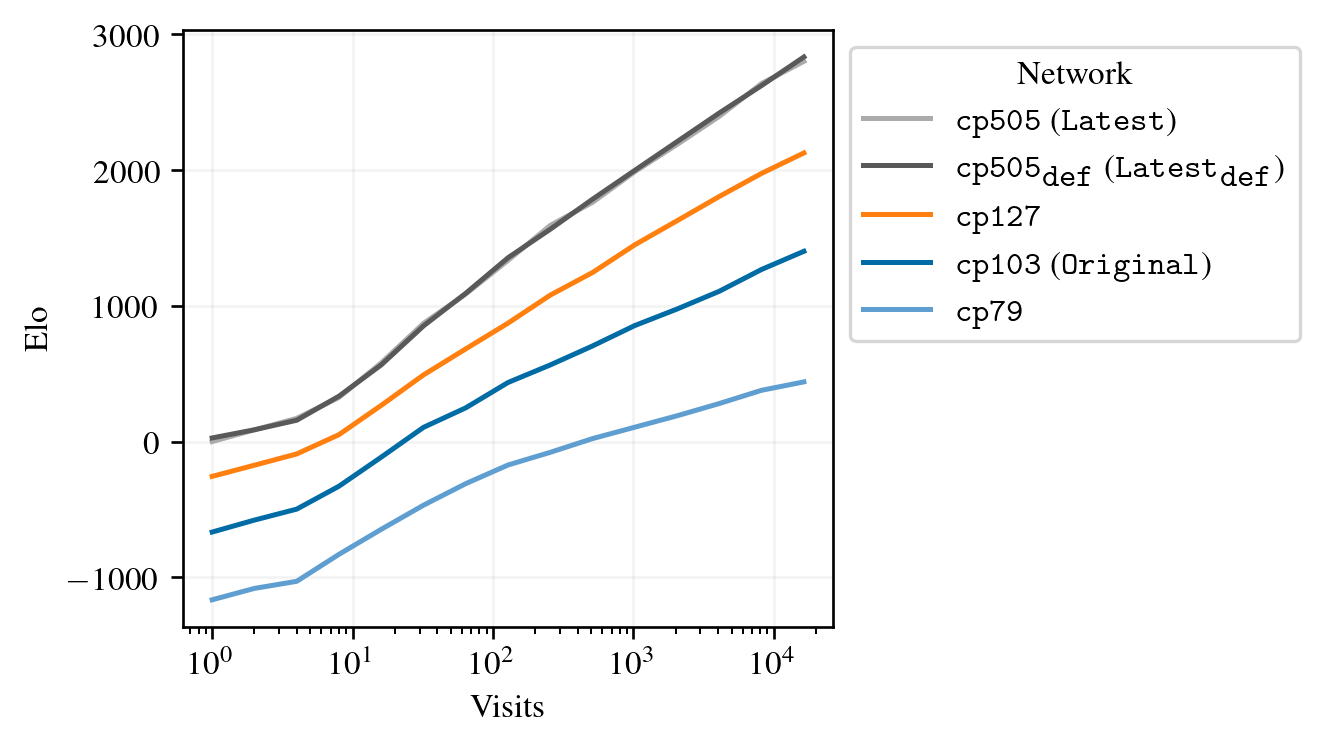

In [2]:
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(fig.get_figwidth() * 0.8) # Make main figure squarish.
plt.subplot(1, 1, 1)

match_path = pathlib.Path("/nas/ucb/ttseng/go_attack/match/elo-221115/summary.txt")
lines = match_path.read_text().splitlines()
elo_lines_start_idx = lines.index("Elos (+/- one approx standard error):")
elo_lines_end_idx = lines.index(
    "Pairwise approx % likelihood of superiority of row over column:"
)
elo_lines = lines[elo_lines_start_idx + 1 : elo_lines_end_idx]

bot_entries: List[Dict[str, Union[float, int, str]]] = []
baseline_elo = 0
for elo_line in elo_lines:
    name = elo_line.split(" ")[0]
    entry = {
        "name": name,
        "rank": name[3] if "bot" in name else name.split("-")[0],
        "visits": int(name.split("-v")[1]),
        "elo": float(elo_line.split(":")[1].split("+/-")[0]),
        "std": float(elo_line.split("+/-")[1]),
    }
    bot_entries.append(entry)
    if name == "cp505-v1":
        baseline_elo = entry["elo"]
# Transpose all Elo scores so that baseline_elo is at 0.
for entry in bot_entries:
    entry["elo"] -= baseline_elo

df = pd.DataFrame(bot_entries)
for rank in sorted(df["rank"].unique()):
    df[df["rank"] == rank].groupby("visits").mean(numeric_only=True).elo.plot(
        label=rank
    )
plt.ylabel("Elo")
plt.xlabel("Visits")
plt.xscale("log")
handles, labels = plt.gca().get_legend_handles_labels()


def label_to_key(label):
    checkpoint_num = int(re.sub("[^0-9]", "", label))
    is_hardened = label[-1] == "h"
    return checkpoint_num - (0.5 if is_hardened else 0)


labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: label_to_key(t[0])))
handles = list(handles)[::-1]
labels = list(labels)[::-1]
for i in range(len(labels)):
    orig_label = labels[i]
    labels[i] = f"$\\texttt{{{orig_label}}}$"
    if orig_label == "cp505":
        labels[i] += " ($\\texttt{Latest}$)"
    elif orig_label == "cp505h":
        labels[i] = "$\\texttt{cp505}_\\texttt{def}$ ($\\texttt{Latest}_\\texttt{def}$)"
    elif orig_label == "cp103":
        labels[i] += " ($\\texttt{Original}$)"
plt.legend(
    handles,
    labels,
    title="Network",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    fancybox=True,
)

plt.gca().grid(True, alpha=0.15)

plt.savefig("elo-by-visits.pgf", backend="pgf")